In [91]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
 
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

#model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

#preprocess.
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import multi_gpu_model
#dl libraraies
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical

# specifically for cnn
from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
 
import tensorflow as tf
import random as rn

# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2                  
import numpy as np  
from tqdm import tqdm
import os                   
from random import shuffle  
from zipfile import ZipFile
from PIL import Image

In [17]:
X=[]
Z=[]
IMG_SIZE=224
adenocarcinoma='/home/softuser/PycharmProjects/efficientnet/wholedata/adenocarcinoma/'
adenoma='/home/softuser/PycharmProjects/efficientnet/wholedata/adenoma/'
cd='/home/softuser/PycharmProjects/efficientnet/wholedata/cd/'
normal='/home/softuser/PycharmProjects/efficientnet/wholedata/normal/'
uc='/home/softuser/PycharmProjects/efficientnet/wholedata/uc/'

In [18]:
def assign_label(img,disease_type):
    return disease_type


In [19]:
def make_train_data(disease_type,DIR):
    for img in tqdm(os.listdir(DIR)):
        label=assign_label(img,disease_type)
        path = os.path.join(DIR,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        
        X.append(np.array(img))
        Z.append(str(label))

In [20]:
make_train_data('adenocarcinoma',adenocarcinoma)
print(len(X))

100%|██████████| 774/774 [00:07<00:00, 107.03it/s]

774


In [21]:
make_train_data('adenoma',adenoma)
print(len(X))

100%|██████████| 776/776 [00:11<00:00, 70.50it/s]

1550


In [22]:
make_train_data('cd',cd)
print(len(X))

100%|██████████| 774/774 [00:03<00:00, 211.78it/s]

2324


In [23]:
make_train_data('normal',normal)
print(len(X))

100%|██████████| 773/773 [00:10<00:00, 71.29it/s]

3097


In [24]:
make_train_data('uc',uc)
print(len(X))

100%|██████████| 774/774 [00:04<00:00, 188.33it/s]

3871


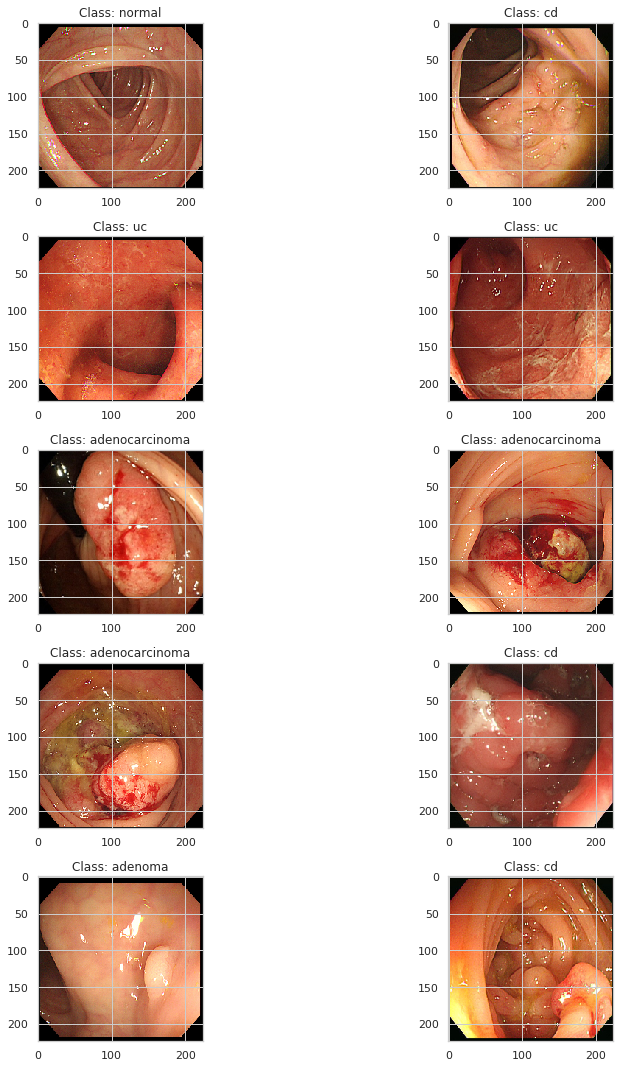

In [25]:
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l=rn.randint(0,len(Z))
        ax[i,j].imshow(X[l])
        ax[i,j].set_title('Class: '+Z[l])
        
plt.tight_layout()

In [26]:
le=LabelEncoder()
Y=le.fit_transform(Z)
Y=to_categorical(Y,5)
X=np.array(X)
X=X/255

In [27]:
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.10,random_state=42)
x_train,x_valid,y_train,y_valid = train_test_split(x_train,y_train,test_size=0.12,random_state=42)

print(len(x_train))
print(len(x_test))
print(len(x_valid))

3065
388
418


In [28]:
np.random.seed(42)
rn.seed(42)
tf.set_random_seed(42)

In [43]:
from numpy import save
save('x_train.npy',x_train)
save('x_valid.npy',x_valid)
save('x_test.npy',x_test)
save('y_train.npy',y_train)
save('y_valid.npy',y_valid)
save('y_test.npy',y_test)

In [2]:
from numpy import load
x_train = load('TrainX.npy')
y_train = load('Trainy.npy')

x_test = load('TestX.npy')
y_test = load('Testy.npy')

x_valid = load('ValidX.npy')
y_valid = load('Testy.npy')

In [ ]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [ ]:
from keras.models import Model
from keras.layers.convolutional import Conv2D
from keras.layers import LeakyReLU, Add, Input, MaxPool2D, UpSampling2D, Concatenate,concatenate, Conv2DTranspose, \
    BatchNormalization, Dropout, Activation
import efficientnet.keras as efn
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D,AveragePooling2D
from keras.layers.merge import concatenate, add,multiply
base_model = efn.EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
from keras.regularizers import l2


def convolution_block(x, filters, size, strides=(1,1), padding='same', activation=True):
    x = Conv2D(filters, size, strides=strides, padding=padding)(x)
    x = BatchNormalization()(x)
    if activation == True:
        x = LeakyReLU(alpha=0.1)(x)
    return x
def residual_block(blockInput, num_filters=1):
    x = LeakyReLU(alpha=0.1)(blockInput)
    x = BatchNormalization()(x)
    blockInput = BatchNormalization()(blockInput)
    x = convolution_block(x, num_filters, (3, 3))
    x = convolution_block(x, num_filters, (3, 3), activation=False)
    x = Add()([x, blockInput])
    return x

def reduce_dimension(layer, n):
    layer = MaxPool2D(pool_size=(n,n),padding='same')(layer)
    return layer
def attention_and_concatenate(first_layer,second_layer,number_of_channel,lastlayer):
    first = Conv2D(number_of_channel,[1,1],strides=[1,1])(first_layer)
    #first = BatchNormalization()(first)
    second = Conv2D(number_of_channel,[1,1],strides=[1,1])(second_layer)
    #second = BatchNormalization()(second)

    f = Activation('relu')(add([first,second]))

    #res_f = residual_block(f,1)
    psi_f = Conv2D(1,[1,1], strides=[1,1])(f)
    psi_f = BatchNormalization()(psi_f)

    rate = Activation('sigmoid')(psi_f)

    att_x = multiply([lastlayer,rate])
    return att_x


def GlobalAveragePoolingLayer(layer,n):
    x = AveragePooling2D(pool_size=(n, n))(layer)

    return x

conv5 = base_model.get_layer('top_activation').output
conv4 = base_model.get_layer('block6a_expand_activation').output
conv3 = base_model.get_layer('block4a_expand_activation').output
conv2 = base_model.get_layer('block3a_expand_activation').output
conv1 = base_model.get_layer('block2a_expand_activation').output

print(conv5.shape)
print(conv4.shape)
print(conv3.shape)
print(conv2.shape)
print(conv1.shape)

reduce_ratio = 50
conv3_maxpool = reduce_dimension(conv3,4)
conv3_globalpool = GlobalAveragePoolingLayer(conv3,4)
conv3_attention = attention_and_concatenate(conv3_maxpool,conv3_globalpool,reduce_ratio,conv5)
conv3_global = GlobalAveragePooling2D()(conv3_attention)
print(conv3_global)


conv4_maxpool = reduce_dimension(conv4,2)
conv4_globalpool = GlobalAveragePoolingLayer(conv4,2)
conv4_attention = attention_and_concatenate(conv4_maxpool,conv4_globalpool,reduce_ratio,conv5)
conv4_global = GlobalAveragePooling2D()(conv4_attention)
print(conv4_global)

conv5_maxpool = reduce_dimension(conv5,1)
conv5_globalpool = GlobalAveragePoolingLayer(conv5,1)
conv5_attention = attention_and_concatenate(conv5_maxpool,conv5_globalpool,reduce_ratio,conv5)
conv5_global = GlobalAveragePooling2D()(conv5_attention)
print(conv5_global)

globalvalue = Add()([conv3_global,conv4_global,conv5_global])
globalvalue1 = concatenate([conv3_global,conv4_global,conv5_global])
#globalvlue = GlobalAveragePooling2D()(globalvalue)
print(globalvalue)
print(globalvalue1)


predictions = Dense(5, activation='softmax')(globalvalue1)
model1 = Model(inputs=base_model.input, outputs=predictions)
print(model1.summary())

In [117]:
model1.compile(optimizer=Adam(lr=0.00001),loss='categorical_crossentropy',metrics=[' '])

In [118]:
History = model1.fit_generator(datagen.flow(x_train,y_train, batch_size=100),
                              epochs = 300, validation_data = (x_test,y_test),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // 100)
model1.save('Efficient01.000001')

Epoch 1/300
30/30 [==============================] - 36s 1s/step - loss: 1.6117 - accuracy: 0.2115 - val_loss: 1.6195 - val_accuracy: 0.2242
Epoch 2/300
30/30 [==============================] - 22s 727ms/step - loss: 1.5581 - accuracy: 0.3123 - val_loss: 1.5713 - val_accuracy: 0.2835
Epoch 3/300
30/30 [==============================] - 22s 724ms/step - loss: 1.4985 - accuracy: 0.4233 - val_loss: 1.5113 - val_accuracy: 0.3711
Epoch 4/300
30/30 [==============================] - 22s 722ms/step - loss: 1.4376 - accuracy: 0.5025 - val_loss: 1.4323 - val_accuracy: 0.4716
Epoch 5/300
30/30 [==============================] - 22s 722ms/step - loss: 1.3663 - accuracy: 0.5703 - val_loss: 1.3332 - val_accuracy: 0.5593
Epoch 6/300
30/30 [==============================] - 22s 724ms/step - loss: 1.2814 - accuracy: 0.6185 - val_loss: 1.2286 - val_accuracy: 0.6031
Epoch 7/300
30/30 [==============================] - 22s 720ms/step - loss: 1.2044 - accuracy: 0.6381 - val_loss: 1.1306 - val_accuracy: 0.

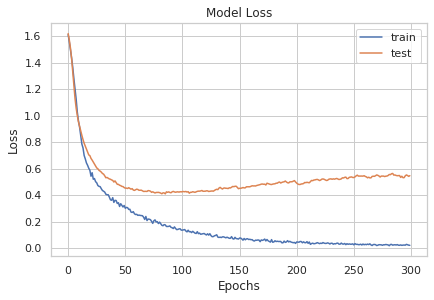

In [119]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

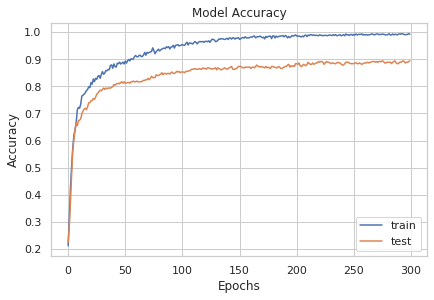

In [120]:
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

In [62]:
datagen1 = ImageDataGenerator(
        )  # randomly flip images


#datagen.fit(x_train)

In [122]:
tta_steps = 20
predictions = []

for i in tqdm(range(tta_steps)):
    preds = model1.predict_generator(datagen.flow(x_test, batch_size=24, shuffle=False), steps = len(x_test)/24)
    predictions.append(preds)

pred = np.mean(predictions, axis=0)

np.mean(np.equal(np.argmax(y_test, axis=-1), np.argmax(pred, axis=-1)))

100%|██████████| 20/20 [01:09<00:00,  3.46s/it]


0.8994845360824743

In [121]:
evaluation = model1.evaluate_generator(datagen.flow(x_test, y_test,
    batch_size=24, shuffle=False),
    steps=x_test.shape[0] // 24, workers=24)
# Print out final values of all metrics
key2name = {'accuracy':'Accuracy', 'loss':'Loss', 
    'val_accuracy':'Validation Accuracy', 'val_loss':'Validation Loss'}
results = []
for i,key in enumerate(model1.metrics_names):
    results.append('%s = %.2f' % (key2name[key], evaluation[i]))
print(", ".join(results))

Loss = 0.26, Accuracy = 0.89


In [124]:
tta_steps = 20
predictions = []

for i in tqdm(range(tta_steps)):
    preds = model1.predict_generator(datagen.flow(x_valid, batch_size=24, shuffle=False), steps = len(x_valid)/24)
    predictions.append(preds)

pred = np.mean(predictions, axis=0)

np.mean(np.equal(np.argmax(y_valid, axis=-1), np.argmax(pred, axis=-1)))

100%|██████████| 20/20 [01:04<00:00,  3.22s/it]


0.8875598086124402

In [123]:
evaluation = model1.evaluate_generator(datagen.flow(x_valid, y_valid,
    batch_size=24, shuffle=False),
    steps=x_valid.shape[0] // 24, workers=24)
# Print out final values of all metrics
key2name = {'accuracy':'Accuracy', 'loss':'Loss', 
    'val_accuracy':'Validation Accuracy', 'val_loss':'Validation Loss'}
results = []
for i,key in enumerate(model1.metrics_names):
    results.append('%s = %.2f' % (key2name[key], evaluation[i]))
print(", ".join(results))

Loss = 0.52, Accuracy = 0.88


In [125]:
# getting predictions on val set.
pred=model1.predict(x_valid)
pred_digits=np.argmax(pred,axis=1)

In [126]:
# now storing some properly as well as misclassified indexes'.
i=0
prop_class=[]
mis_class=[]

for i in range(len(y_valid)):
    if(np.argmax(y_valid[i])==pred_digits[i]):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(y_valid)):
    if(not np.argmax(y_valid[i])==pred_digits[i]):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

print(len(prop_class))
print(len(mis_class))

8
8


In [109]:
str([pred_digits[prop_class[0]]])

'[3]'

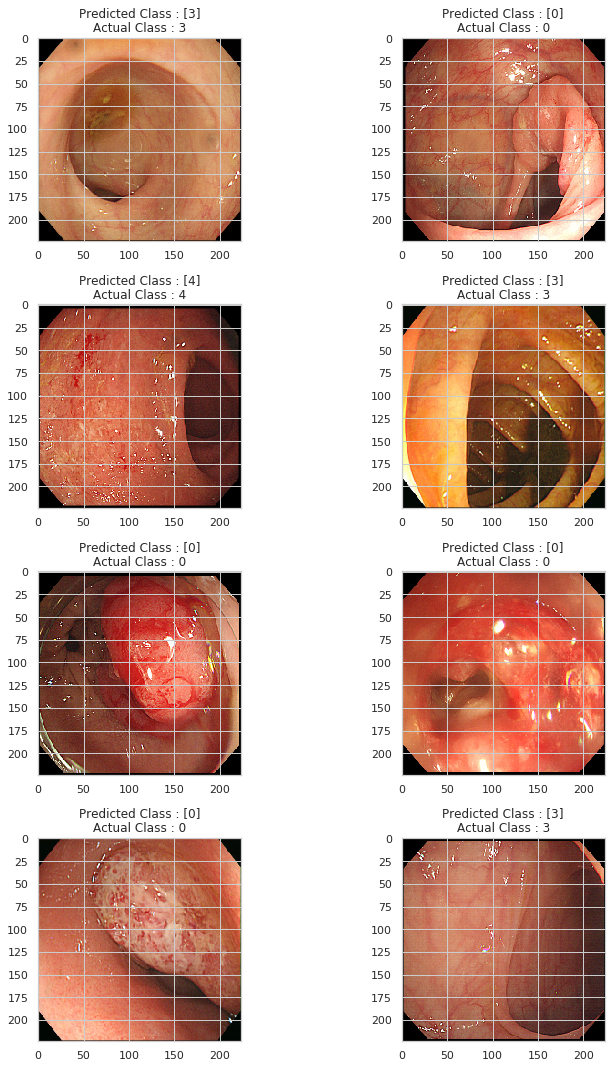

In [127]:
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')


count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(x_valid[prop_class[count]])
        ax[i,j].set_title("Predicted Class : "+str([pred_digits[prop_class[count]]])+"\n"+"Actual Class : "+str(np.argmax([y_valid[prop_class[count]]])))
        plt.tight_layout()
        count+=1

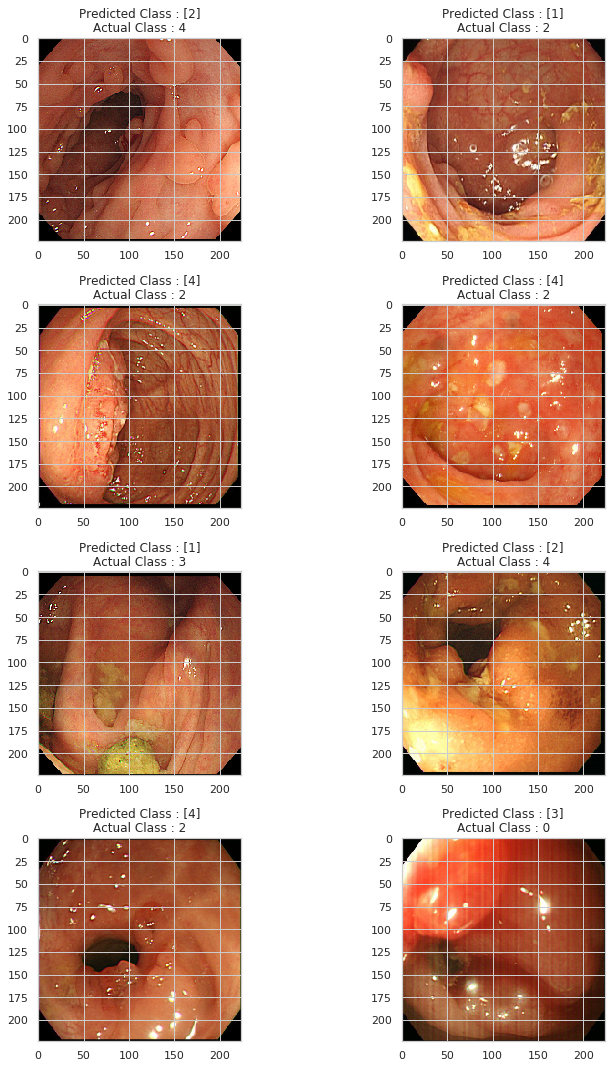

In [128]:
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')


count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(x_valid[mis_class[count]])
        ax[i,j].set_title("Predicted Class : "+str([pred_digits[mis_class[count]]])+"\n"+"Actual Class : "+str(np.argmax([y_valid[mis_class[count]]])))
        plt.tight_layout()
        count+=1